In [29]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!pip install -q seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Set plotting style basics
plt.rcParams['figure.figsize'] = (8,5)
sns.set(style='whitegrid', palette='muted')


In [38]:
# Option A: If you're running locally and have data/table1.csv in repo:
try:
    students = pd.read_csv('data/table1.csv')
    print("Loaded data/table1.csv")
except FileNotFoundError:
    # Option B: fallback - create a small sample synthetic dataset (if user hasn't provided CSV)
    print("data/table1.csv not found. Creating a small sample dataset for demo.")
    students = pd.DataFrame({
        'student_id': range(1,201),
        'gender': np.random.choice(['female','male'], 200, p=[0.52,0.48]),
        'race/ethnicity': np.random.choice(['group A','group B','group C','group D','group E'], 200),
        'parental level of education': np.random.choice([
            "bachelor's degree","some college","master's degree","associate's degree","high school","some high school"
        ], 200),
        'lunch': np.random.choice(['standard','free/reduced'], 200, p=[0.8,0.2]),
        'test preparation course': np.random.choice(['completed','none'], 200, p=[0.3,0.7]),
        'math score': np.clip(np.random.normal(65, 15, 200).round().astype(int), 0, 100),
        'reading score': np.clip(np.random.normal(68, 12, 200).round().astype(int), 0, 100),
        'writing score': np.clip(np.random.normal(66, 13, 200).round().astype(int), 0, 100)
    })
    # ensure student_id column exists when using real dataset (if CSV didn't have it)
    if 'student_id' not in students.columns:
        students.insert(0, 'student_id', range(1, len(students)+1))

students.head()


data/table1.csv not found. Creating a small sample dataset for demo.


,student_id,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,1,female,group B,associate's degree,standard,completed,87,60,52
1,2,male,group D,bachelor's degree,standard,none,48,71,54
2,3,male,group E,associate's degree,free/reduced,completed,67,66,55
3,4,male,group B,associate's degree,standard,completed,59,91,64
4,5,male,group E,some college,standard,none,71,61,63


In [39]:
if 'student_id' not in students.columns:
    students.insert(0, 'student_id', range(1, len(students)+1))
students.shape


(200, 9)

In [40]:
import os

if os.path.exists('data/table2.csv'):
    study_logs = pd.read_csv('data/table2.csv')
    print("Loaded data/table2.csv")
else:
    # Create synthetic study logs: multiple logs per student (1-4 logs)
    logs = []
    rng = np.random.default_rng(42)
    for sid in students['student_id']:
        n_logs = rng.integers(1,5)  # 1 to 4 logs per student
        for i in range(n_logs):
            logs.append({
                'student_id': sid,
                'log_id': f"{sid}_{i+1}",
                'date': pd.Timestamp('2024-09-01') + pd.to_timedelta(rng.integers(0,120), unit='D'),
                'study_hours': max(0.0, round(rng.normal(6, 3), 1)),  # hours/week
                'focus_level': rng.integers(1,6)  # 1-5 scale
            })
    study_logs = pd.DataFrame(logs)
    os.makedirs('data', exist_ok=True)
    study_logs.to_csv('data/table2.csv', index=False)
    print("Created synthetic data/table2.csv and saved it.")

study_logs.head()


Created synthetic data/table2.csv and saved it.


,student_id,log_id,date,study_hours,focus_level
0,1,1_1,2024-12-02,2.9,3
1,2,2_1,2024-09-11,0.1,4
2,2,2_2,2024-11-03,6.4,5
3,2,2_3,2024-11-26,5.9,4
4,2,2_4,2024-12-10,8.6,3


In [41]:
print("Students shape:", students.shape)
print("Study logs shape:", study_logs.shape)
print("\nStudents columns:", students.columns.tolist())
print("Study logs columns:", study_logs.columns.tolist())


Students shape: (200, 9)
Study logs shape: (499, 5)

Students columns: ['student_id', 'gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']
Study logs columns: ['student_id', 'log_id', 'date', 'study_hours', 'focus_level']


In [42]:
merged = pd.merge(study_logs, students, on='student_id', how='left')
print("Merged shape:", merged.shape)
merged.head()


Merged shape: (499, 13)


,student_id,log_id,date,study_hours,focus_level,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,1,1_1,2024-12-02,2.9,3,female,group B,associate's degree,standard,completed,87,60,52
1,2,2_1,2024-09-11,0.1,4,male,group D,bachelor's degree,standard,none,48,71,54
2,2,2_2,2024-11-03,6.4,5,male,group D,bachelor's degree,standard,none,48,71,54
3,2,2_3,2024-11-26,5.9,4,male,group D,bachelor's degree,standard,none,48,71,54
4,2,2_4,2024-12-10,8.6,3,male,group D,bachelor's degree,standard,none,48,71,54


In [43]:
print("Missing values per column:\n", merged.isna().sum())

# Drop duplicates (if any)
before = merged.shape[0]
merged = merged.drop_duplicates()
after = merged.shape[0]
print(f"Dropped {before-after} duplicate rows.")


Missing values per column:
 student_id                     0
log_id                         0
date                           0
study_hours                    0
focus_level                    0
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64
Dropped 0 duplicate rows.


In [44]:
# Ensure 'date' is datetime and numeric columns are numeric
merged['date'] = pd.to_datetime(merged['date'], errors='coerce')
# Convert study_hours to numeric
merged['study_hours'] = pd.to_numeric(merged['study_hours'], errors='coerce')
merged.dtypes


,0
student_id,int64
log_id,object
date,datetime64[ns]
study_hours,float64
focus_level,int64
gender,object
race/ethnicity,object
parental level of education,object
lunch,object
test preparation course,object


In [45]:
# For numeric columns: impute with median. For categorical: impute with mode.
num_cols = merged.select_dtypes(include=['number']).columns.tolist()
cat_cols = merged.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Numeric imputation
num_imputer = SimpleImputer(strategy='median')
merged[num_cols] = num_imputer.fit_transform(merged[num_cols])

# Categorical imputation (mode)
for c in cat_cols:
    if merged[c].isna().any():
        merged[c].fillna(merged[c].mode().iloc[0], inplace=True)

print("Missing after imputation:\n", merged.isna().sum())


Numeric cols: ['student_id', 'study_hours', 'focus_level', 'math score', 'reading score', 'writing score']
Categorical cols: ['log_id', 'gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
Missing after imputation:
 student_id                     0
log_id                         0
date                           0
study_hours                    0
focus_level                    0
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [46]:
le = LabelEncoder()
for col in ['gender', 'test preparation course', 'lunch']:
    if col in merged.columns:
        merged[col + '_enc'] = le.fit_transform(merged[col].astype(str))

# One-hot encode 'parental level of education' as an example
merged = pd.get_dummies(merged, columns=['parental level of education'], drop_first=True)

merged.head()


,student_id,log_id,date,study_hours,focus_level,gender,race/ethnicity,lunch,test preparation course,math score,reading score,writing score,gender_enc,test preparation course_enc,lunch_enc,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school
0,1.0,1_1,2024-12-02,2.9,3.0,female,group B,standard,completed,87.0,60.0,52.0,0,0,1,False,False,False,False,False
1,2.0,2_1,2024-09-11,0.1,4.0,male,group D,standard,none,48.0,71.0,54.0,1,1,1,True,False,False,False,False
2,2.0,2_2,2024-11-03,6.4,5.0,male,group D,standard,none,48.0,71.0,54.0,1,1,1,True,False,False,False,False
3,2.0,2_3,2024-11-26,5.9,4.0,male,group D,standard,none,48.0,71.0,54.0,1,1,1,True,False,False,False,False
4,2.0,2_4,2024-12-10,8.6,3.0,male,group D,standard,none,48.0,71.0,54.0,1,1,1,True,False,False,False,False


In [47]:
scaler = StandardScaler()
scale_cols = ['math score','reading score','writing score','study_hours','focus_level']
present_scale_cols = [c for c in scale_cols if c in merged.columns]
merged[[c + '_scaled' for c in present_scale_cols]] = scaler.fit_transform(merged[present_scale_cols])
merged[[c + '_scaled' for c in present_scale_cols]].head()


,math score_scaled,reading score_scaled,writing score_scaled,study_hours_scaled,focus_level_scaled
0,1.343187,-0.741426,-0.929011,-1.055012,-0.049833
1,-1.230891,0.199977,-0.774666,-2.039557,0.660647
2,-1.230891,0.199977,-0.774666,0.175671,1.371127
3,-1.230891,0.199977,-0.774666,-0.000141,0.660647
4,-1.230891,0.199977,-0.774666,0.949243,-0.049833


In [49]:
desc = merged[['math score','reading score','writing score','study_hours','focus_level']].describe().T
desc['median'] = merged[['math score','reading score','writing score','study_hours','focus_level']].median()
desc


,count,mean,std,min,25%,50%,75%,max,median
math score,499.0,66.649299,15.166256,15.0,57.0,67.0,78.0,100.0,67.0
reading score,499.0,68.663327,11.696414,37.0,60.0,68.0,76.5,97.0,68.0
writing score,499.0,64.038076,12.970950,32.0,55.0,64.0,73.0,100.0,64.0
study_hours,499.0,5.900401,2.846805,0.0,4.0,5.9,7.8,14.4,5.9
focus_level,499.0,3.070140,1.408911,1.0,2.0,3.0,4.0,5.0,3.0


In [50]:
#Correlations
corr_cols = ['math score','reading score','writing score','study_hours','focus_level']
corr = merged[corr_cols].corr()
print("Correlation matrix:\n", corr.round(2))


Correlation matrix:
                math score  reading score  writing score  study_hours  \
math score           1.00           0.05          -0.06        -0.04   
reading score        0.05           1.00          -0.11        -0.02   
writing score       -0.06          -0.11           1.00        -0.01   
study_hours         -0.04          -0.02          -0.01         1.00   
focus_level          0.01          -0.04          -0.00         0.02   

               focus_level  
math score            0.01  
reading score        -0.04  
writing score        -0.00  
study_hours           0.02  
focus_level           1.00  


In [58]:
#Identify outliers using IQR method for numeric columns (math/read/write/study_hours)
outlier_info = {}
for col in ['math score','reading score','writing score','study_hours']:
    if col in merged.columns:
        Q1 = merged[col].quantile(0.25)
        Q3 = merged[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = merged[(merged[col] < lower) | (merged[col] > upper)]
        outlier_info[col] = {'lower': lower, 'upper': upper, 'n_outliers': outliers.shape[0]}
outlier_info


{'math score': {'lower': np.float64(25.5),
  'upper': np.float64(109.5),
  'n_outliers': 3},
 'reading score': {'lower': np.float64(35.25),
  'upper': np.float64(101.25),
  'n_outliers': 0},
 'writing score': {'lower': np.float64(28.0),
  'upper': np.float64(100.0),
  'n_outliers': 0},
 'study_hours': {'lower': np.float64(-1.6999999999999993),
  'upper': np.float64(13.5),
  'n_outliers': 3}}

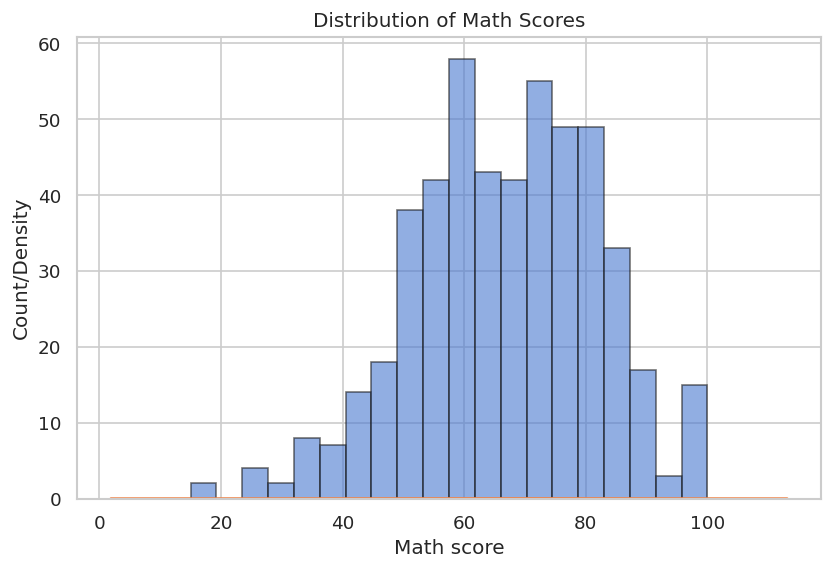

In [52]:
plt.figure(figsize=(8,5))
plt.hist(merged['math score'], bins=20, edgecolor='k', alpha=0.6)
sns.kdeplot(merged['math score'], bw_adjust=1.0, fill=False)
plt.title('Distribution of Math Scores')
plt.xlabel('Math score')
plt.ylabel('Count/Density')
plt.show()


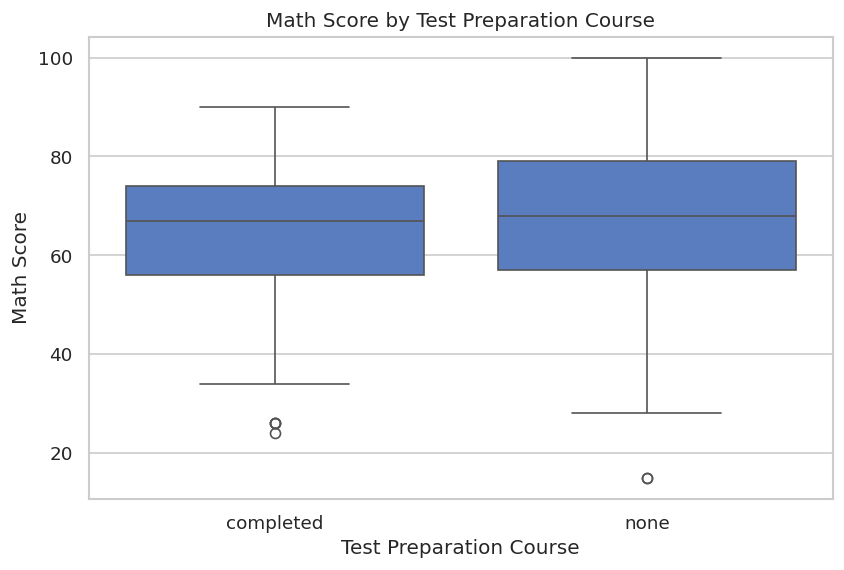

In [53]:
plt.figure(figsize=(8,5))
order = merged['test preparation course'].unique()
sns.boxplot(x='test preparation course', y='math score', data=merged, order=order)
plt.title('Math Score by Test Preparation Course')
plt.xlabel('Test Preparation Course')
plt.ylabel('Math Score')
plt.show()


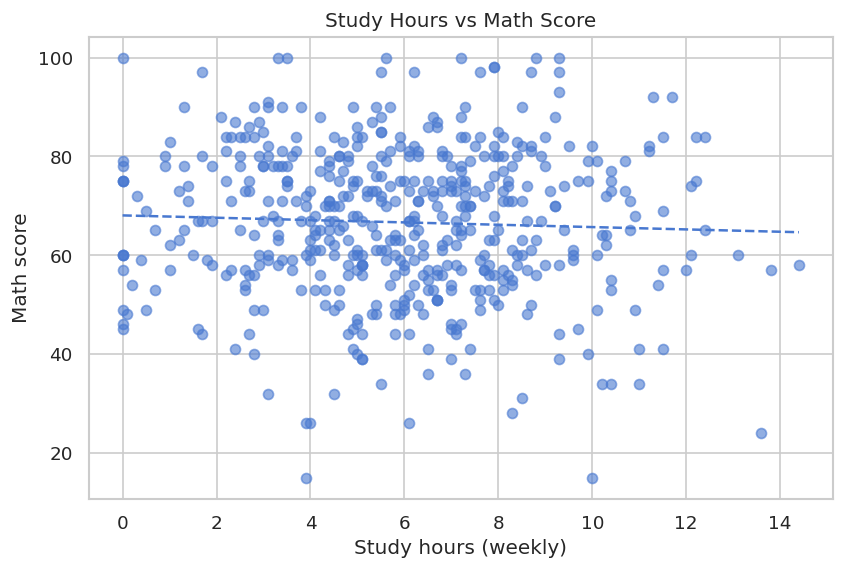

In [54]:
plt.figure(figsize=(8,5))
plt.scatter(merged['study_hours'], merged['math score'], alpha=0.6)
plt.xlabel('Study hours (weekly)')
plt.ylabel('Math score')
plt.title('Study Hours vs Math Score')
# Add a trend line (linear)
m, b = np.polyfit(merged['study_hours'], merged['math score'], 1)
xvals = np.linspace(merged['study_hours'].min(), merged['study_hours'].max(), 100)
plt.plot(xvals, m*xvals + b, linestyle='--')
plt.show()


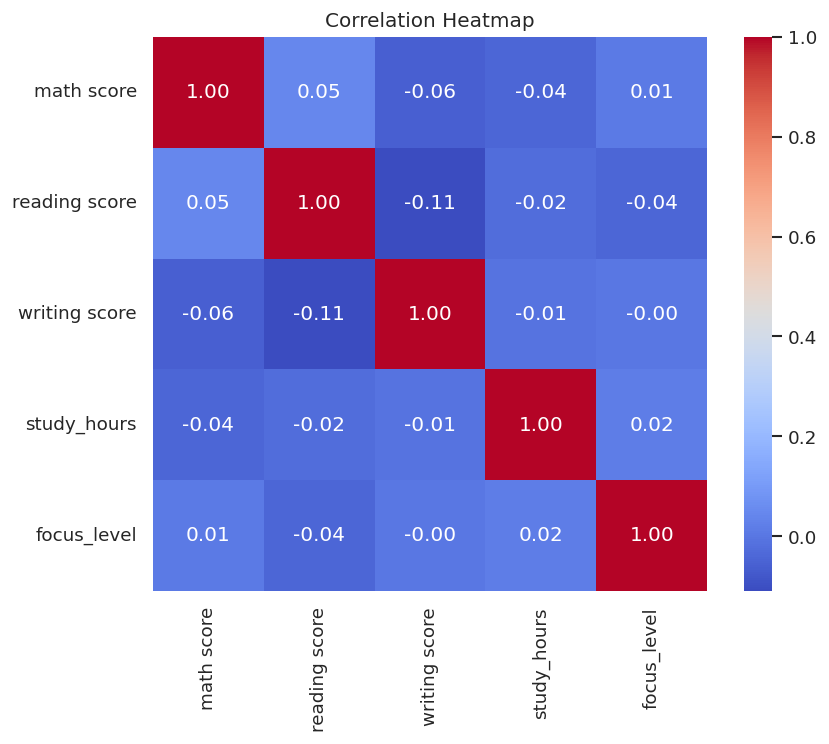

In [55]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()
